In [1]:
import numpy as np
import pandas as pd 
from pathlib import Path
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.nn import functional as F
from transformers import AutoImageProcessor, ViTMAEConfig, ViTMAEModel, ViTMAEForPreTraining
from torch.utils.data import DataLoader, Dataset

from engine_hms_model import CustomDataset, JobConfig, ModelConfig 
from engine_hms_trainer import load_kaggle_data, TARGETS, TARGETS_PRED, BRAIN_ACTIVITY, DEVICE

/home/shiyi/miniconda3/envs/kaggle/lib/python3.11/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [2]:
from engine_hms_model import CustomModel 

model = CustomModel(ModelConfig)

model.model.num_features

1408

In [2]:
print(TARGETS)
print(TARGETS_PRED)
print(BRAIN_ACTIVITY)
print(DEVICE)

['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']
['seizure_pred', 'lpd_pred', 'gpd_pred', 'lrda_pred', 'grda_pred', 'other_pred']
['seizure', 'lpd', 'gpd', 'lrda', 'grda', 'other']
cuda


In [3]:
train_easy, train_hard, all_specs, all_eegs = load_kaggle_data(JobConfig.PATHS, JobConfig.ENTROPY_SPLIT)

my_dataset = CustomDataset(
            train_easy, TARGETS, ModelConfig, all_specs, all_eegs, mode="train")

X, y = my_dataset[0]
print(X.shape)
print(y.shape)

torch.Size([8, 128, 256])
torch.Size([6])


In [11]:
class CustomMAE(nn.Module):
    def __init__(self, backbone="facebook/vit-mae-base", num_classes=6, mlp_hidden_size=512, mae_dropout=0.05, mae_attention_dropout=0.05):
        super(CustomMAE, self).__init__()

        mae_config = ViTMAEConfig.from_pretrained(backbone)
        mae_config.hidden_dropout_prob = mae_dropout
        mae_config.attention_probs_dropout_prob = mae_attention_dropout

        self.vitmae = ViTMAEModel.from_pretrained(backbone, config=mae_config)
        self.mlp_head = nn.Sequential(
            nn.Linear(self.vitmae.config.hidden_size, mlp_hidden_size),
            nn.GELU(),
            nn.Linear(mlp_hidden_size, num_classes)
        )
    
    def __reshape_input(self, x):
        # Split the input into two halves
        # Concatenate each half along the height dimension
        concat_1 = torch.cat(torch.chunk(x[:, :4, :, :], 4, dim=1), dim=2)
        concat_2 = torch.cat(torch.chunk(x[:, 4:, :, :], 4, dim=1), dim=2)
        # Concatenate the two parts along the width dimension
        concatenated = torch.cat((concat_1, concat_2), dim=3)
        # Stack to get 3 channels and resize
        stacked = concatenated.repeat(1, 3, 1, 1)  # Replicate the single channel to get 3 channels
        resized = F.interpolate(stacked, size=(224, 224), mode='bilinear', align_corners=False)
        return resized
    
    def forward(self, x):
        x = self.__reshape_input(x)

        outputs = self.vitmae(pixel_values=x)
        last_hidden_state = outputs.last_hidden_state
        logits = self.mlp_head(last_hidden_state[:, 0])
        return logits


In [23]:
from huggingface_hub import list_models

# List models containing 'vit' in their model id (useful for Vision Transformer models, for example)
models = list_models(filter="vit")

for model in models:
    print(model.modelId)

Aftabhussain/Tomato_Leaf_Classifier
AkshatSurolia/ViT-FaceMask-Finetuned
Amrrs/indian-foods
Amrrs/south-indian-foods
Frodnar/bee-likes
Giuliano/places
HHousen/household-rooms
LorenzoDeMattei/lawn-weeds
Neto71/sea_mammals
NhatPham/vit-base-patch16-224-recylce-ft
Rajaram1996/FacialEmoRecog
SauravMaheshkar/vit-base-patch16-imagenette
Sena/dog
Sena/flowers
SriramSridhar78/sriram-car-classifier
Suzana/new-york-tokyo-london
WinKawaks/vit-small-patch16-224
WinKawaks/vit-tiny-patch16-224
adhisetiawan/test-vit
adhisetiawan/vit-resisc45
ajanco/greens
akahana/asl-vit
akahana/vit-base-cats-vs-dogs
b25mayank3/shirt_identifier
black/simple_kitchen
clip-italian/clip-italian-final
clip-italian/clip-italian
davanstrien/iiif_manuscript_vit
davanstrien/vit_flyswot_test
dayyass/trocr-base-handwritten-vit-encoder
drab/Infrastructures
edixo/road_good_damaged_condition
eliwill/rare-puppers
facebook/deit-base-patch16-224
facebook/deit-base-patch16-384
facebook/deit-small-patch16-224
facebook/deit-tiny-patch16

In [12]:
# Instantiate your model
model = CustomMAE()

# Forward pass through the model
input_x = X.unsqueeze(0)
logits = model(input_x)

# Here, you can compare `logits` to your labels `y` using an appropriate loss function
# For demonstration, let's print the shape of logits
print(logits.shape)  # Expected to be [batch_size, num_classes]

torch.Size([1, 6])


In [6]:
import matplotlib.pyplot as plt

In [6]:
from kl_divergence import score as kl_score


def calc_kl_div(p, q, criterion):
    
    p = torch.tensor(p.astype(np.float32)).unsqueeze(0)
    q = torch.tensor(q.astype(np.float32)).unsqueeze(0)
    return criterion(F.log_softmax(p, dim=1), q).item()

def calc_kaggle_score(solution, submission):
    solution = solution.to_frame().T
    solution[TARGETS] = solution[TARGETS].astype(np.float32)
    submission = submission.to_frame().T
    submission.columns = ['eeg_id'] + TARGETS
    submission[TARGETS] = submission[TARGETS].astype(np.float32)
    
    return kl_score(solution, submission, 'eeg_id')

def evaluate_oof(oof_csv_path):
    oof_df = pd.read_csv(oof_csv_path)
    softmax = nn.Softmax(dim=1)
    criterion = nn.KLDivLoss(reduction="batchmean")

    oof_df["kl_loss"] = oof_df.apply(lambda row: 
        calc_kl_div(row[TARGETS_PRED].values, row[TARGETS].values, criterion), axis=1
        )

    kl_loss_all = criterion(
        F.log_softmax(torch.tensor(oof_df[TARGETS_PRED].values.astype(np.float32)), dim=1),
        torch.tensor(oof_df[TARGETS].values.astype(np.float32)),
        )

    print(f"KL Loss All: {kl_loss_all}")
    print(f"KL Loss Mean: {oof_df['kl_loss'].mean()}")

    y_pred = oof_df[TARGETS].values.astype(np.float32)
    oof_df[TARGETS_PRED] = softmax(torch.tensor(y_pred)).numpy()

    return oof_df, kl_loss_all

In [3]:
# oof_2, kl_loss_all = evaluate_oof("./outputs/ENet_b2_xymasking_regularize_001/ENet_b2_xymasking_regularized_oof_2.csv")

oof_df = pd.read_csv("./outputs/ENet_b2_xymasking_remove_less/ENet_b2_xymasking_remove_less_oof_2.csv")

In [19]:
oof_df[TARGETS_PRED]

,seizure_pred,lpd_pred,gpd_pred,lrda_pred,grda_pred,other_pred
0,-2.856440,-1.453575,-1.987391,0.746231,1.756803,2.947237
1,-0.132455,0.976122,2.514811,-2.230804,-0.903525,-0.077702
2,-2.051862,-1.106435,0.013815,-0.455452,1.594818,2.031838
3,2.187205,-0.721841,-1.360288,0.025824,-1.179540,0.426571
4,-3.262609,-2.272628,-3.051954,1.091852,1.886737,4.088077
...,...,...,...,...,...,...
20178,0.488905,-1.162680,3.860361,-3.307617,-1.455859,1.299301
20179,-2.881070,0.435698,2.420086,-1.590420,-1.197464,2.351787
20180,-2.615789,0.729481,-2.132716,1.724840,0.758378,1.594180
20181,-3.870118,0.267378,-2.722668,0.747809,1.184877,2.972718


In [17]:
criteria = nn.KLDivLoss(reduction="batchmean")

y_pred = torch.tensor(oof_df[TARGETS_PRED].values.astype(np.float32))
y_true = torch.tensor(oof_df[TARGETS].values.astype(np.float32))

kl_loss = criteria(F.log_softmax(y_pred, dim=1), y_true)
print(f"KL Loss: {kl_loss}")


KL Loss: 0.6635837554931641


In [30]:
softmax = nn.Softmax(dim=1)
criteria(torch.log(softmax(y_pred)), y_true)

tensor(0.6636)

In [24]:
F.log_softmax(y_pred, dim=1)

tensor([[-6.1664, -4.7635, -5.2974, -2.5637, -1.5532, -0.3627],
        [-2.9850, -1.8764, -0.3378, -5.0834, -3.7561, -2.9303],
        [-4.7372, -3.7918, -2.6715, -3.1408, -1.0905, -0.6535],
        ...,
        [-5.3196, -1.9743, -4.8365, -0.9790, -1.9454, -1.1096],
        [-7.1405, -3.0030, -5.9930, -2.5225, -2.0855, -0.2976],
        [-4.5570, -1.0993, -4.2320, -2.0705, -3.0371, -0.7597]])

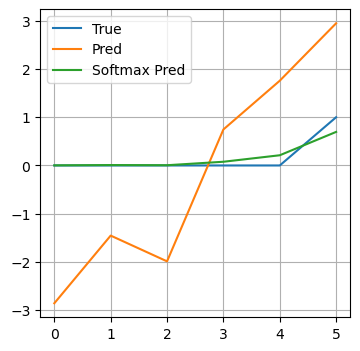

In [28]:
plt.figure(figsize=(4,4))
plt.plot(y_true[0].detach().numpy(), label="True")
plt.plot(y_pred[0].detach().numpy(), label="Pred")
plt.plot(softmax(y_pred)[0].detach().numpy(), label="Softmax Pred")
plt.grid()
plt.legend()
plt.show()

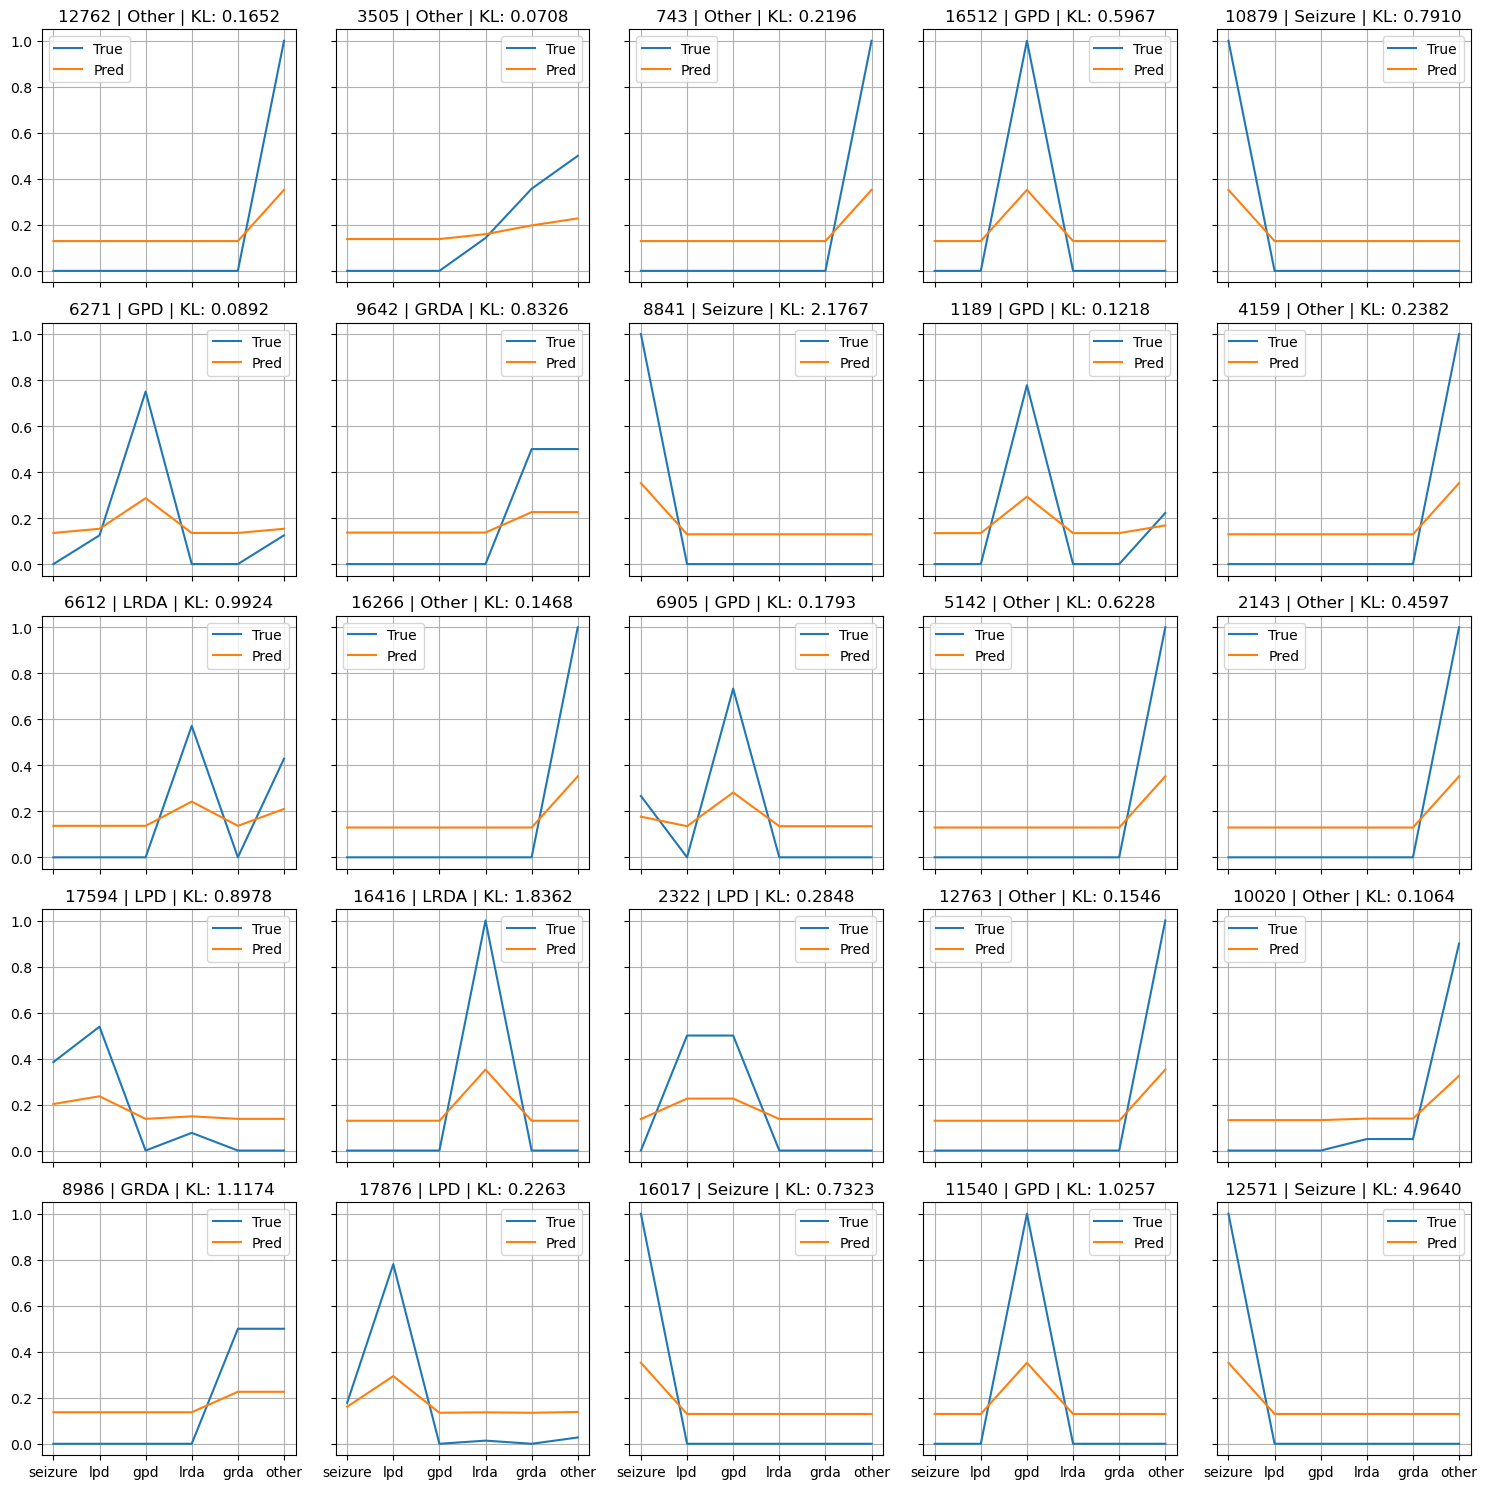

In [20]:

fig, axes = plt.subplots(5, 5, figsize=(15, 15), sharex=True, sharey=True)

# rows = oof_df.iloc[-len(axes.ravel()):, :]
rows = oof_2.sample(len(axes.ravel()))

for i, (idx, row) in enumerate(rows.iterrows()):

    ax = axes.ravel()[i]
    ax.plot(row[TARGETS].values, label='True')
    ax.plot(row[TARGETS_PRED].values, label='Pred')
    ax.set_title(f"{idx} | {row['target']} | KL: {row['kl_loss']:.4f}")
    ax.set_xticks(range(6))
    ax.set_xticklabels(BRAIN_ACTIVITY)
    ax.grid(True)
    ax.legend()

fig.tight_layout()
plt.show()